In [5]:
import furniture_bench

import numpy as np

from src.behavior import get_actor
from src.eval.eval_utils import get_model_from_api_or_cached

from src.common.files import get_processed_paths, path_override
from torch.utils.data import DataLoader
from src.dataset.dataset import ImageDataset
from src.train.bc import to_native

import torch
from src.behavior.base import Actor
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from tqdm import tqdm

PyTorch version 2.3.0+cu121
Device count 1
/data/scratch/ankile/isaacgym/python/isaacgym/_bindings/src/gymtorch


Using /data/scratch/ankile/.cache as PyTorch extensions root...
Emitting ninja build file /data/scratch/ankile/.cache/gymtorch/build.ninja...
Building extension module gymtorch...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module gymtorch...
/data/scratch/ankile/miniconda3/envs/rr/lib/python3.8/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
13:09:22 INFO: This is wandb-osh v1.2.2 using communication directory /afs/csail.mit.edu/u/a/ankile/.wandb_osh_command_dir
/data/scratch/ankile/robust-rearrangement/src/train/bc.py:100: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="../config", config_name="base")


=== Activate TF32 training? Deactivated for now...


In [6]:
run_id_naive = "real-ol-demo-scaling-1/3js1f6n1"
run_id_upwt = "real-ol-demo-scaling-1/31xxjkpb"
run_id_confusion4 = "real-ol-demo-scaling-1/1knzc1b4"
run_id_confusion3 = "real-ol-demo-scaling-1/jaa8pst0"
run_id_confusion2 = "real-ol-demo-scaling-1/kp0mo0b0"

In [7]:
# Get the config to load in the standard model with only pretrained weights
cfg, _ = get_model_from_api_or_cached(run_id_naive, "latest", wandb_mode="online")

cfg

{'data': {'suffix': None, 'furniture': ['one_leg_full_new', 'one_leg_render_demos_brighter', 'one_leg_render_rppo_brighter'], 'pad_after': True, 'randomness': ['low', 'med', 'med_perturb'], 'test_split': 0.05, 'data_subset': None, 'demo_source': ['teleop', 'rollout'], 'environment': ['real', 'sim'], 'obs_horizon': 1, 'demo_outcome': 'success', 'pred_horizon': 32, 'augment_image': True, 'normalization': 'min_max', 'action_horizon': 8, 'load_into_memory': True, 'dataloader_workers': 16, 'include_future_obs': False, 'data_paths_override': None, 'minority_class_power': False, 'predict_past_actions': False, 'parts_poses_in_robot_frame': False}, 'actor': {'name': 'diffusion', 'loss_fn': 'MSELoss', 'clip_sample': True, 'flatten_obs': False, 'obs_horizon': 1, 'pred_horizon': 32, 'beta_schedule': 'squaredcos_cap_v2', 'action_horizon': 8, 'projection_dim': 128, 'diffusion_model': {'name': 'transformer', 'n_emb': 256, 'n_head': 4, 'n_layer': 8, 'p_drop_emb': 0, 'causal_attn': True, 'flatten_obs':

In [8]:
actor: Actor = get_actor(cfg=cfg, device="cuda")

/data/scratch/ankile/miniconda3/envs/rr/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/data/scratch/ankile/miniconda3/envs/rr/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/scratch/ankile/miniconda3/envs/rr/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Total parameters: 31.52M
normalizer: 0.00M parameters
encoder1: 11.18M parameters
encoder2: 11.18M parameters
encoder1_proj: 0.07M parameters
encoder2_proj: 0.07M parameters
loss_fn: 0.00M parameters
model: 9.04M parameters
layernorm1: 0.00M parameters
layernorm2: 0.00M parameters


In [9]:
# Turn off the actor's training mode and gradient computation
actor.eval()

for param in actor.parameters():
    param.requires_grad = False

In [10]:
actor.model.eval()

DiffusionTransformer(
  (input_emb): Linear(in_features=10, out_features=256, bias=True)
  (drop): Dropout(p=0, inplace=False)
  (time_emb): SinusoidalPosEmb()
  (cond_obs_emb): Linear(in_features=272, out_features=256, bias=True)
  (encoder): Sequential(
    (0): Linear(in_features=256, out_features=1024, bias=True)
    (1): Mish()
    (2): Linear(in_features=1024, out_features=256, bias=True)
  )
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=1024, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=1024, out_features=256, bias=T

In [11]:
actor.model.training, actor.encoder1.training, actor.encoder2.training

(False, False, False)

In [13]:
if cfg.data.data_paths_override is None:
    data_path = get_processed_paths(
        controller=to_native(cfg.control.controller),
        domain=to_native(cfg.data.environment),
        task=to_native(cfg.data.furniture),
        demo_source=to_native(cfg.data.demo_source),
        randomness=to_native(cfg.data.randomness),
        demo_outcome=to_native(cfg.data.demo_outcome),
        suffix=to_native(cfg.data.suffix),
    )
else:
    data_path = path_override(cfg.data.data_paths_override)

print(f"Using data from {data_path}")

dataset = ImageDataset(
    dataset_paths=data_path,
    pred_horizon=cfg.data.pred_horizon,
    obs_horizon=cfg.data.obs_horizon,
    action_horizon=cfg.data.action_horizon,
    # data_subset=cfg.data.data_subset,
    data_subset=5,
    control_mode=cfg.control.control_mode,
    predict_past_actions=cfg.data.predict_past_actions,
    pad_after=cfg.data.get("pad_after", True),
    max_episode_count=cfg.data.get("max_episode_count", None),
    minority_class_power=cfg.data.get("minority_class_power", False),
)

# Create dataloaders
trainload_kwargs = dict(
    dataset=dataset,
    # batch_size=cfg.training.batch_size,
    batch_size=64,
    num_workers=cfg.data.dataloader_workers,
    shuffle=True,
    pin_memory=True,
    drop_last=False,
    persistent_workers=False,
)

trainloader = DataLoader(**trainload_kwargs)

Using data from [PosixPath('/data/scratch/ankile/furniture-data/processed/diffik/real/one_leg_full_new/teleop/low/success.zarr'), PosixPath('/data/scratch/ankile/furniture-data/processed/diffik/sim/one_leg_render_demos_brighter/teleop/med/success.zarr'), PosixPath('/data/scratch/ankile/furniture-data/processed/diffik/sim/one_leg_render_rppo_brighter/rollout/med/success.zarr'), PosixPath('/data/scratch/ankile/furniture-data/processed/diffik/sim/one_leg_render_demos_brighter/teleop/med_perturb/success.zarr')]


Loading zarr files:   0%|          | 0/4 [00:00<?, ?it/s]

















Loading zarr files:  25%|██▌       | 1/4 [00:09<00:28,  9.54s/it]

















Loading zarr files:  50%|█████     | 2/4 [00:15<00:14,  7.17s/it]

















Loading zarr files:  75%|███████▌  | 3/4 [00:20<00:06,  6.47s/it]

















Loading zarr files: 100%|██████████| 4/4 [00:22<00:00,  5.60s/it]

Loading dataset of 20 episodes:
  ('one_leg_full_new', 'teleop', 'low', 'success'): 5 episodes, 2494
  ('one_leg_render_demos_brighter', 'teleop', 'med', 'success'): 5 episodes, 2295
  ('one_leg_render_rppo_brighter', 'rollout', 'med', 'success'): 5 episodes, 2516
  ('one_leg_render_demos_brighter', 'teleop', 'med_perturb', 'success'): 5 episodes, 2249


In [14]:
data_path

[PosixPath('/data/scratch/ankile/furniture-data/processed/diffik/real/one_leg_full_new/teleop/low/success.zarr'),
 PosixPath('/data/scratch/ankile/furniture-data/processed/diffik/sim/one_leg_render_demos_brighter/teleop/med/success.zarr'),
 PosixPath('/data/scratch/ankile/furniture-data/processed/diffik/sim/one_leg_render_rppo_brighter/rollout/med/success.zarr'),
 PosixPath('/data/scratch/ankile/furniture-data/processed/diffik/sim/one_leg_render_demos_brighter/teleop/med_perturb/success.zarr')]

In [15]:
def get_embeddings(actor: Actor, batch):
    img1 = batch["color_image1"].to("cuda").squeeze()
    emb1 = actor.encoder1_proj(actor.encoder1(img1))

    img2 = batch["color_image2"].to("cuda").squeeze()
    emb2 = actor.encoder2_proj(actor.encoder2(img2))

    return emb1, emb2

In [16]:
def get_embeddings_and_domain_labels(actor: Actor, trainloader, sample_size=None):
    # Initialize empty lists to store embeddings and domain labels
    embeddings = []
    domain_labels = []

    # Iterate over the dataset
    for batch in tqdm(trainloader):
        emb1, emb2 = get_embeddings(actor, batch)

        # Concatenate the embeddings into a single tensor of shape (batch_size, 2 * embedding_size)
        emb = torch.cat([emb1, emb2], dim=1)
        embeddings.append(emb.cpu().numpy())

        domain_labels.extend(batch["domain"].cpu().numpy().tolist())

    # Concatenate the embeddings and convert to numpy array
    embeddings = np.concatenate(embeddings, axis=0)
    domain_labels = np.array(domain_labels).reshape(-1)

    # Print the average standard deviation of the embeddings
    print(
        f"Average standard deviation of embeddings: {np.mean(np.std(embeddings, axis=0))}"
    )

    # If sample_size is not None, sample a subset of the embeddings and domain labels
    # Stratified by domain label
    if sample_size is not None:
        sampled_embeddings = []
        sampled_domain_labels = []

        for domain_label in np.unique(domain_labels):
            idx = np.where(domain_labels == domain_label)[0]
            idx = np.random.choice(idx, size=sample_size, replace=False)

            sampled_embeddings.append(embeddings[idx])
            sampled_domain_labels.extend(domain_labels[idx].tolist())

        embeddings = np.concatenate(sampled_embeddings, axis=0)
        domain_labels = np.array(sampled_domain_labels).reshape(-1)

    return embeddings, domain_labels

In [17]:
simcolor = "#2398DA"
realcolor = "#E34A6F"


def visualize_embeddings_tsne(embeddings, domain_labels, title=None, ax=None):
    # Apply t-SNE to reduce the dimensionality to 2
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_tsne = tsne.fit_transform(embeddings)

    # Split the embeddings based on the domain labels
    embeddings_domain1 = embeddings_tsne[domain_labels == 0]
    embeddings_domain2 = embeddings_tsne[domain_labels == 1]

    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))

    # Plot the embeddings in two different colors
    ax.scatter(
        embeddings_domain1[:, 0],
        embeddings_domain1[:, 1],
        color=simcolor,
        label="Sim",
        alpha=0.2,
        s=2,
    )
    ax.scatter(
        embeddings_domain2[:, 0],
        embeddings_domain2[:, 1],
        color=realcolor,
        label="Real",
        alpha=0.2,
        s=2,
    )
    # ax.xlabel('t-SNE Dimension 1')
    # ax.ylabel('t-SNE Dimension 2')
    ax.legend(frameon=False)

    if title is not None:
        ax.set_title(title + " (t-SNE)")


def visualize_embeddings_pca(embeddings, domain_labels, title=None, ax=None):
    # Apply PCA to reduce the dimensionality to 2
    pca = PCA(n_components=2)
    embeddings_pca = pca.fit_transform(embeddings)

    # Split the embeddings based on the domain labels
    embeddings_domain1 = embeddings_pca[domain_labels == 0]
    embeddings_domain2 = embeddings_pca[domain_labels == 1]

    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))

    # Plot the embeddings in two different colors
    ax.scatter(
        embeddings_domain1[:, 0],
        embeddings_domain1[:, 1],
        color=simcolor,
        label="Sim",
        alpha=0.2,
        s=2,
    )
    ax.scatter(
        embeddings_domain2[:, 0],
        embeddings_domain2[:, 1],
        color=realcolor,
        label="Real",
        alpha=0.2,
        s=2,
    )
    # ax.xlabel('PCA Dimension 1')
    # ax.ylabel('PCA Dimension 2')
    ax.legend(frameon=False)

    if title is not None:
        ax.set_title(title + " (PCA)")


def visualize_embeddings(embeddings, domain_labels, title=None):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    visualize_embeddings_tsne(embeddings, domain_labels, title, ax=axs[0])
    visualize_embeddings_pca(embeddings, domain_labels, title, ax=axs[1])

    plt.tight_layout()
    plt.show()

### Plot embeddings for the pretrained R3M model

In [18]:
sample_size = 1_000

100%|██████████| 142/142 [00:09<00:00, 14.67it/s]


Average standard deviation of embeddings: 0.047664985060691833


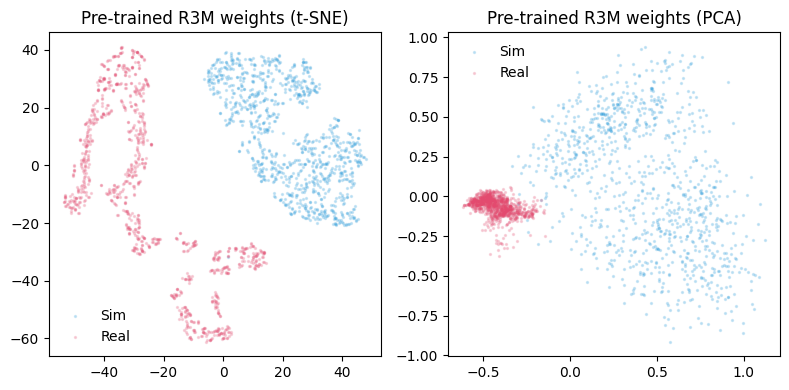

In [19]:
embeddings, domain_labels = get_embeddings_and_domain_labels(
    actor, trainloader, sample_size=sample_size
)

title = "Pre-trained R3M weights"
visualize_embeddings(embeddings, domain_labels, title)

### Plot embeddings for co-trained model with no tricks

In [20]:
def plot_embeddings(run_id, title, sample_size=1_000):
    # Get weights
    _, wts = get_model_from_api_or_cached(run_id, "latest", wandb_mode="online")

    # Load the weights into the actor
    state_dict = torch.load(wts)
    if "model_state_dict" in state_dict:
        state_dict = state_dict["model_state_dict"]

    if "model._dummy_variable" in state_dict:
        del state_dict["model._dummy_variable"]

    actor.load_state_dict(state_dict)

    # Get the embeddings and domain labels
    embeddings, domain_labels = get_embeddings_and_domain_labels(
        actor, trainloader, sample_size=sample_size
    )

    # Visualize the embeddings using t-SNE and PCA
    visualize_embeddings(embeddings, domain_labels, title)

100%|██████████| 142/142 [00:07<00:00, 18.66it/s]


Average standard deviation of embeddings: 0.06744559109210968


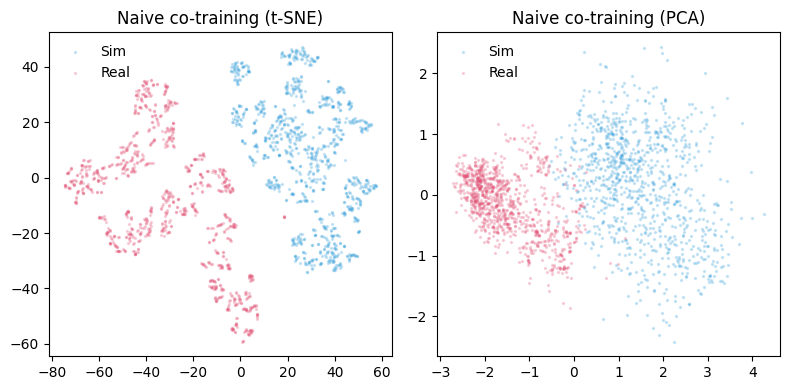

In [21]:
plot_embeddings(run_id_naive, "Naive co-training")

### Plot embeddings for co-trained model with up-weighting of real data

100%|██████████| 142/142 [00:07<00:00, 18.84it/s]


Average standard deviation of embeddings: 0.0622093491256237


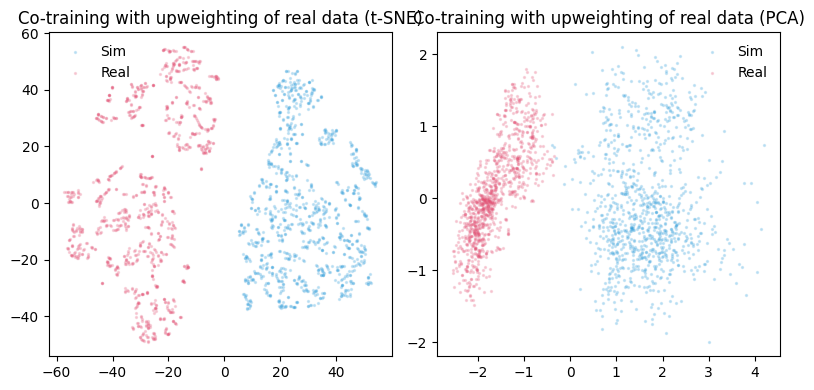

In [22]:
plot_embeddings(run_id_upwt, "Co-training with upweighting of real data")

### Plot embeddings for co-trained model with confusion loss and up-weighting of real data

100%|██████████| 142/142 [00:07<00:00, 18.82it/s]


Average standard deviation of embeddings: 0.07472585141658783


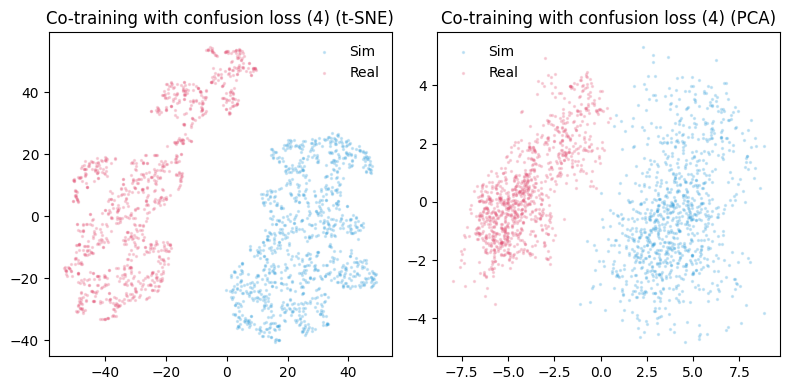

In [23]:
plot_embeddings(run_id_confusion4, "Co-training with confusion loss (4)")

100%|██████████| 142/142 [00:07<00:00, 18.62it/s]


Average standard deviation of embeddings: 0.08681218326091766


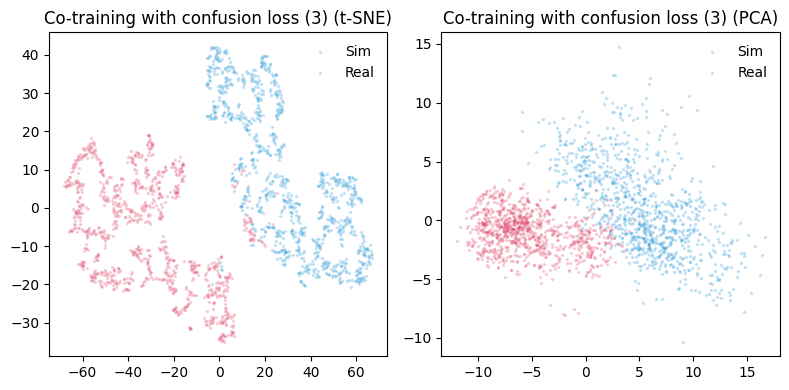

100%|██████████| 142/142 [00:07<00:00, 18.56it/s]


Average standard deviation of embeddings: 0.06357969343662262


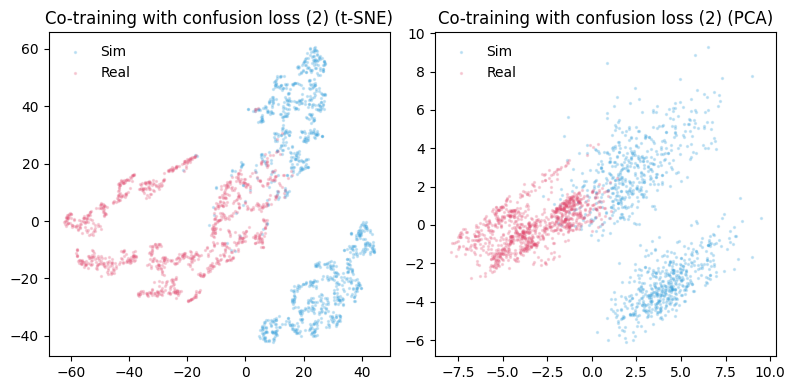

In [24]:
plot_embeddings(run_id_confusion3, "Co-training with confusion loss (3)")
plot_embeddings(run_id_confusion2, "Co-training with confusion loss (2)")